# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [3]:
df = pd.read_csv(r"C:\Users\danie\Downloads\customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [7]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [8]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [9]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [10]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [12]:
# Display basic information
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.3+ 

# The below cell shows a very high level of imbalance towards flights that were not booked vs flights that were.

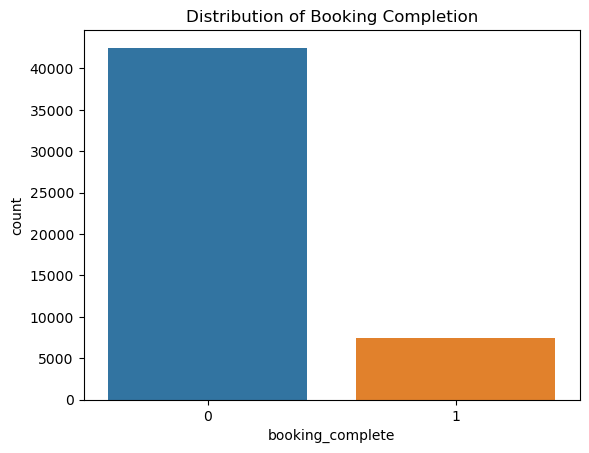

In [13]:
# Visualize target variable
sns.countplot(x=df["booking_complete"])
plt.title("Distribution of Booking Completion")
plt.show()

In [14]:
print(df["booking_complete"])

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: booking_complete, Length: 50000, dtype: int64


# Logistic Regression and Random Forest models are coded and trained below here.

In [15]:
# Define categorical and numerical features
categorical_features = ["sales_channel", "trip_type", "flight_day", "booking_origin"]
numerical_features = ["num_passengers", "purchase_lead", "length_of_stay", 
                      "flight_hour", "flight_duration", 
                      "wants_extra_baggage", "wants_preferred_seat"]

In [16]:
# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [17]:
# Split Data
X = df.drop("booking_complete", axis=1)
y = df["booking_complete"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# Define Models
log_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=500))
])

rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train Models
log_reg.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration',
                                                   'wants_extra_baggage',
                                                   'wants_preferred_seat']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sales_channel', 'trip_type',
                                                   'flight_day',
                                                   'booking_origin'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [19]:
# Predictions
y_pred_log = log_reg.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# The models do not perform very well because of high imbalance with bookings. There are steps that can be taken to improve this such as Undersampling, or Oversampling using SMOTE. Other options to improve the models include using GridSearchCV to find the best parameters, or feature engineering which would include options like grouping, possibly by route or even trip time, or even creating new variables. 

In [20]:
# Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))
print("AUC Score:", roc_auc_score(y_test, y_pred_log))

print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("AUC Score:", roc_auc_score(y_test, y_pred_rf))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8504
           1       0.62      0.01      0.01      1496

    accuracy                           0.85     10000
   macro avg       0.73      0.50      0.46     10000
weighted avg       0.82      0.85      0.78     10000

AUC Score: 0.5023798174875869

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      8504
           1       0.51      0.13      0.21      1496

    accuracy                           0.85     10000
   macro avg       0.69      0.55      0.56     10000
weighted avg       0.81      0.85      0.81     10000

AUC Score: 0.5532938887519431


In [21]:
# Feature Importance for Random Forest
feature_names = (numerical_features + 
                 list(rf_model.named_steps["preprocessor"]
                      .named_transformers_["cat"]
                      .get_feature_names_out(categorical_features)))

importances = rf_model.named_steps["classifier"].feature_importances_
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Even with poor model performance the most important features for predicting bookings are shown here.

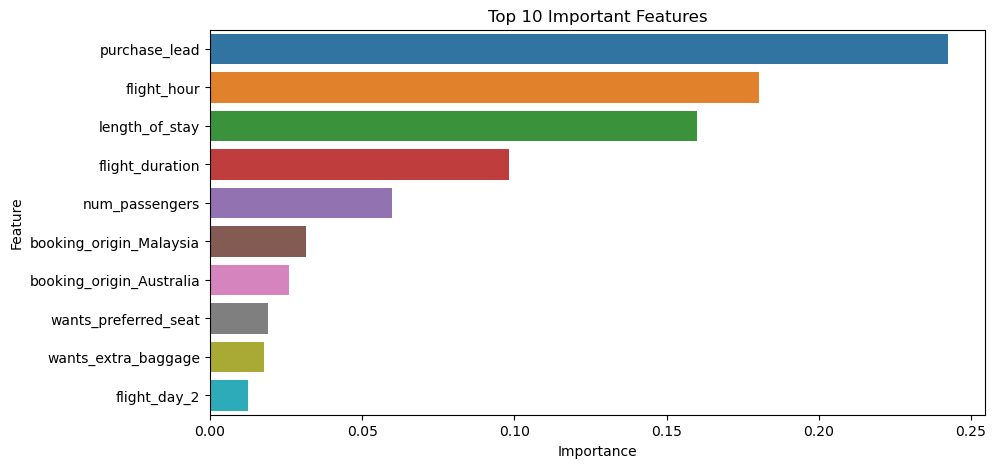

In [42]:
# Plot Feature Importance
plt.figure(figsize=(10,5))
sns.barplot(x=feature_importance_df.Importance[:10], y=feature_importance_df.Feature[:10])
plt.title("Top 10 Important Features")

# Save the figure before showing it
plt.savefig("important features.png", dpi=300, bbox_inches="tight")  # Exports as PNG

plt.show()

## Both Logistic Regression and Random Forest were tested for predictions using the data in its current form. As we can see purchase price, flight hours, length of stay and flight duration are some of the most important factors to predict bookings. Random Forest is a better option versus Logistic Regression when trying to predict bookings because customer bookings tend to be non-linear in behavior.  However in its current state this data is not very reliable to predict bookings. This is due to severe imbalance having over 8000 non-bookings vs about 1500 bookings. As mentioned before options like using SMOTE, GridSearchCV, feature engineering, or even using different models such as XGBoost or LightGBM should be incorporated to improve predictions. 
